# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [ ]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [ ]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [ ]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

senReleasesDF[:100:10]

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [ ]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
senReleasesW2V['president'][:10] #Shortening because it's very large

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index2word[10]

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.most_similar('president')

In [ ]:
senReleasesW2V.most_similar('war')

Find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

For this exercise, I have compared COCA news documents from 1990/1991 to the google news vectors that were built from google news dataset to figure out if the semantic associations of certain important political words have changed over time. Specifically I have focused on war related words, as the first gulf war in Iraq was fought in those years.
The exact documents that went into creating the google news dataset is not known, but the dataset was created around 2012, and is in all probability consisting of newer articles than from 1990/91 and then includes the second gulf war. 

In the code blocks below, I load the files from 1990/1991(which are the only files in that directory, I removed the others) and analyze the results.

In [ ]:
corpora_address = "../week-6/COCA"
coca_texts = lucem_illud_2020.loadDavies(corpora_address)

In [ ]:
print("No. of documents loaded",len((coca_texts.keys())))

In [ ]:
#Cleaning the data
for k in coca_texts.keys():
    coca_texts[k]=[" ".join(coca_texts[k]).replace("< p > ","")]

In [ ]:
newsDF=pandas.DataFrame.from_dict(coca_texts,orient='index')
newsDF.head()
newsDF.columns=["text"]
newsDF.head()


In [ ]:
#tokenizing the sentences
newsDF['tokenized_sents'] = newsDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])


In [ ]:
newsDF['normalized_sents'] = newsDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [ ]:
#using pickle to save and load the dataframe for faster loading
newsDF.to_pickle("./newsDF.pkl")

In [3]:
newsDF = pandas.read_pickle("./newsDF.pkl")

In [121]:
#create the word2Vec model
newsW2V = gensim.models.word2vec.Word2Vec(newsDF['normalized_sents'].sum())

In [122]:
m1=newsW2V

In [ ]:
#save the model for faster loading later on
m1.save("NewsEmbeddings")

In [2]:
m1=gensim.models.Word2Vec.load("NewsEmbeddings")

In [126]:
#printing most frequent words.
print("Most frequent 100 words:", m1.wv.index2entity[:100])

Most frequent 100 words: ['said', '$', 'says', 'new', 'people', 'year', 'years', 'time', 'like', 'mr', 'state', 'city', 'world', 'president', 'percent', 'american', 'way', 'day', 'work', 'government', 'war', 'think', 'old', 'long', 'good', 'home', 'going', 'u.s', 'national', 'school', 'high', 'soviet', 'states', 'life', 'san', 'country', 'united', 'public', 'york', 'black', 'want', 'washington', 'know', 'house', 'today', 'company', 'week', 'children', 'money', 'women', 'right', 'little', 've', 'come', 'game', 'business', 'm', 'political', 'white', 'bush', 'team', 'officials', 'best', 'news', 'big', 'got', 'season', 'military', 'man', 'iraq', 'family', 'use', 'second', 'times', 'left', 'ago', 'end', 'university', 'called', 'john', 'lot', 'group', 'days', 'place', 'including', 'center', 'air', 'party', 'major', 'director', 'great', 'told', 'help', 'system', 'market', 'things', 'area', 'came', 'francisco', 'east']


We see a lot of political words like goverment, military, war, president, u.s, and words resonant of that time, like soviet, bush(George H.W. Bush), Iraq(from first Gulf war).

In [127]:
numWords= 100
targetWords = m1.wv.index2word[:numWords]

In [128]:
m1sub=[]
for word in targetWords:
    m1sub.append(m1[word])
m1sub=np.array(m1sub)

In [129]:
#for my visualizations, I have decided to look at PCA and TSNE visualization seperately
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(m1sub)
reducedPCA_data = pcaWords.transform(m1sub)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(m1sub)

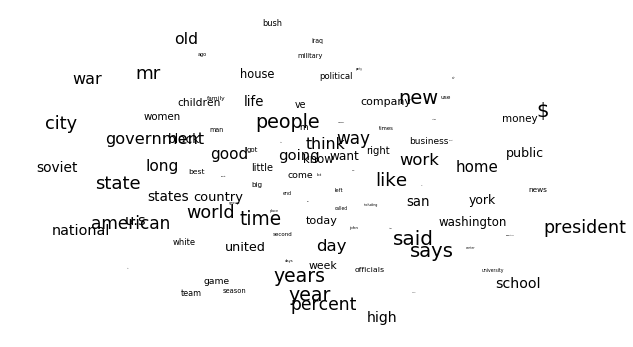

In [130]:
#plotting theTSNE visualization
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

It seems like TSNE is capturing local associations than global associations. Words like bush, iraq, miliary,political is clustered together, and words like president and washington are clustered together. But each cluster is seperate from each other. However we can see some major themes(iraq, war, president) in the text, which will help our analysis.

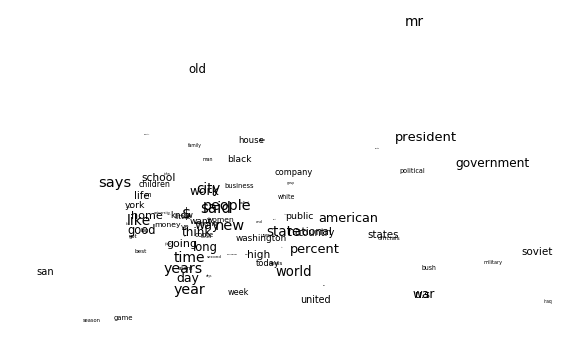

In [131]:
#plotting the PCA visualization
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

PCA seems to have more variability in the distances it captures. But more importantly, it captures global associations. The problem with TSNE of local associations but no global associations mentioned above seems to be solved. For instance: president, goverment, iraq, bush, war, soviet, political all belong to the same "cluster" whereas they were split in the TSNE visualization. 

In [ ]:
Below, I perform some word simliarties to begin to understand the vector embedding space.

In [132]:
m1.most_similar("news")

[('cnn', 0.7449272871017456),
 ('broadcast', 0.6926010847091675),
 ('newspapers', 0.6684376001358032),
 ('network', 0.6640119552612305),
 ('reporting', 0.6629951596260071),
 ('broadcasts', 0.6550604104995728),
 ('weekly', 0.6477890014648438),
 ('reporter', 0.6475802659988403),
 ('abc', 0.6417906284332275),
 ('coverage', 0.6386721730232239)]

The reasonableness of this query in the vector space, suggests that even though we chose about 6000 documents, we have a reasonable embedding space.

In [133]:
m1.most_similar("war")

[('disobedience', 0.7398648858070374),
 ('persian', 0.7217761278152466),
 ('libertarians', 0.716130256652832),
 ('servants', 0.6967906951904297),
 ('wars', 0.693993330001831),
 ('vietnam', 0.6337761878967285),
 ('crisis', 0.626186192035675),
 ('battle', 0.6234490871429443),
 ('fighting', 0.5941678285598755),
 ('conflict', 0.587417483329773)]

Interestingly war is still associated with Vietnam and disobedience than the then ongoing war in Iraq. This suggests that news articles used a different name for the First Gulf war(just as they did during the second gulf war, often called "conflict with Iraq", "liberation of Iraq", etc.

In [134]:
m1.most_similar("journalist")

[('ali', 0.7859123945236206),
 ('rabbi', 0.7791092991828918),
 ('kidnapped', 0.7704187631607056),
 ('waite', 0.7701046466827393),
 ('historian', 0.7682353258132935),
 ('vladimir', 0.7665528059005737),
 ('borba', 0.7653626799583435),
 ('garrison', 0.7612490653991699),
 ('respected', 0.7608950138092041),
 ('kahane', 0.760352373123169)]

The proximity of rabbi to journalist is very interesting, and so is respected. This suggests an reverence towards journalists in news articles of the time.

In [135]:
m1.most_similar("men")

[('women', 0.7777819633483887),
 ('woman', 0.6521433591842651),
 ('husbands', 0.6418757438659668),
 ('female', 0.6379066705703735),
 ('male', 0.6204431653022766),
 ('males', 0.5976687669754028),
 ('wives', 0.586895227432251),
 ('3-meter', 0.5808749198913574),
 ('vipers', 0.5756202340126038),
 ('agers', 0.574444055557251)]

In [136]:
m1.most_similar("women")

[('men', 0.7777818441390991),
 ('female', 0.6845829486846924),
 ('minorities', 0.6570558547973633),
 ('male', 0.650871992111206),
 ('wives', 0.6101282835006714),
 ('adults', 0.5941382646560669),
 ('mothers', 0.5901459455490112),
 ('gay', 0.588685154914856),
 ('pregnant', 0.5863944292068481),
 ('husbands', 0.5847878456115723)]

We get a bunch of gendered terms being most simliar to both men and women but interestingly women are also associated with words like minorities and gay. This suggest we are capturing conversations about social justice in the news corpora even as early as 90/91.

In [ ]:
I perform some analogy tests below.

In [137]:
mm = m1.most_similar(positive=['journalist','woman'], negative=['man'])
for m in mm:
    print (m)

('kahane', 0.7479691505432129)
('kidnapped', 0.7367396354675293)
('rabbi', 0.716681957244873)
('prominent', 0.7162034511566162)
('fellow', 0.7106069326400757)
('observer', 0.7037312984466553)
('borba', 0.6983530521392822)
('editors', 0.6926689147949219)
('waite', 0.6904481649398804)
('colleagues', 0.6852350234985352)


This particular analogy isn't insightful, although the possible candidates include people with low agency objects(kidnapped, observer). This suggests a passive role for women in the corpus.

In [138]:
mm = m1.most_similar(positive=['president','woman'], negative=['man'])
for m in mm:
    print (m)

('presidents', 0.7259188890457153)
('versa', 0.6932865381240845)
('chairman', 0.6095808148384094)
('administration', 0.5978301167488098)
('administrations', 0.5926615595817566)
('barbara', 0.5741320848464966)
('george', 0.5567322373390198)
('presidential', 0.5488193035125732)
('silverado', 0.5484504699707031)
('appointee', 0.5356423258781433)


Hard to infer much from this analogy task in terms of gender roles, except Barbara bush(mother of then president HW bush shows up) and so does appointee which continues the pattern of associating passive roles with women in this corpus.

In [141]:
mm = m1.most_similar(positive=['nurse','man'], negative=['woman'])
for m in mm:
    print (m)

('clinic', 0.8055128455162048)
('physician', 0.7958341240882874)
('dentist', 0.7519091367721558)
('hospital', 0.7446486949920654)
('cardiac', 0.7299456596374512)
('indigent', 0.7207581996917725)
('psychiatric', 0.7194459438323975)
('raped', 0.7100444436073303)
('boarder', 0.7082751393318176)
('pneumonia', 0.70616215467453)


The word Nurse when given a male attribute, gives physician and dentist, capturing gender bias in these documents.

In [144]:
mm = m1.most_similar(positive=['wars','president'], negative=['war'])
for m in mm:
    print (m)

('presidents', 0.6859259605407715)
('versa', 0.6577973365783691)
('premier', 0.5638840198516846)
('chairman', 0.5447474122047424)
('administrations', 0.5358525514602661)
('director', 0.5074631571769714)
('quebeckers', 0.5027059316635132)
('commentator', 0.484036386013031)
('appointee', 0.4839371144771576)
('praised', 0.4823583960533142)


Out model of only 6000 documents seem to capture, plurality as it gives 'presidents' as the highest candidate for this analogy task.

In [4]:
mm = m1.most_similar(positive=['bush','vietnam'], negative=['iraq'])
for m in mm:
    print (m)

('reagan', 0.5955963134765625)
('spar', 0.5788742303848267)
('carter', 0.5777533650398254)
('truman', 0.5735921263694763)
('eisenhower', 0.5643807649612427)
('nixon', 0.5627210140228271)
('perles', 0.5597009658813477)
('veterans', 0.5381999611854553)
('anwar', 0.5256026983261108)
('inauguration', 0.5250068306922913)


In wanted to see if we can infer the presidents during the vietnam user using the "Bush:Iraq" relation. Interesting that nixon is not higher but reagan and carter are, given they are both presidents who came into power after the vietnam war.

In [147]:
mm = m1.most_similar(positive=['washington','iraq'], negative=['states'])
for m in mm:
    print (m)

('gulf', 0.5755504965782166)
('baghdad', 0.5627267360687256)
('riyadh', 0.5318119525909424)
('tehran', 0.5056657791137695)
('united', 0.5025691390037537)
('cairo', 0.4943722188472748)
('kuwait', 0.4895973205566406)
('allied', 0.4882400631904602)
('panama', 0.4855172038078308)
('iraqi', 0.48539799451828003)


In [65]:
mm = m1.most_similar(positive=['washington','iraq'], negative=['united','states'])
for m in mm:
    print (m)

('baghdad', 0.44975537061691284)
('riyadh', 0.4067331850528717)
('iraqi', 0.39430633187294006)
('briefing', 0.3841095566749573)
('pentagon', 0.3742128312587738)
('bombing', 0.3673343360424042)
('fallouja', 0.3651654124259949)
('post', 0.36272960901260376)
('zakhu', 0.35691165924072266)
('basra', 0.3546799123287201)


In [148]:
m1.most_similar('iraq')

[('withdrawal', 0.8523744940757751),
 ('allied', 0.8493318557739258),
 ('kuwait', 0.8484979867935181),
 ('iraqi', 0.8338255882263184),
 ('deployment', 0.8302556276321411),
 ('iraqis', 0.8296290636062622),
 ('withdraw', 0.8292543888092041),
 ('emirate', 0.8254193067550659),
 ('invasion', 0.8178001642227173),
 ('baghdad', 0.8111965656280518)]

Finally I do a similiarity query for Iraq, since I thought it will be useful to compare the associations here to the associations in the google news corpus, which I also explored below.

The conversation around Iraq seems to be mainly around their Kuwaiti invastion that precipitated the first gulf war and the subsquent deployment of troops from US and allies which led to the withdrawal of Iraq from Kuwait. Therefore this similiarity query captures a lot of aspects of the First Gulf war.

In [4]:
#load the google news vectors trained on the google news corpus
m2=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [152]:
print("Most frequent 100 words:", m2.wv.index2entity[:100])

Most frequent 100 words: ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before']


It's clear that the google news corpus has not been cleaned.

In [200]:
#For visualization, take 100 of the top 1000 vocabulary for purpose of visualization.
import random
random.seed(13)
sublist=random.sample(m2.wv.index2entity[:1000],100)
#print("Randomly chosen 100 words from most frequent thousand words:", sublist)

In [201]:
m2sub=[]
for word in sublist:
    #print((m2[word]).shape)
    m2sub.append((m2[word]))
m2sub=np.array(m2sub)
#print(m2sub.shape)

In [208]:
#Once again, I plot PCA and TSNE visualizations seperately
pcaWords2 = sklearn.decomposition.PCA(n_components = 2).fit(m2sub)
reducedPCA_data2 = pcaWords.transform(m2sub.T)
tsneWords2 = sklearn.manifold.TSNE(n_components = 2).fit_transform(m2sub)

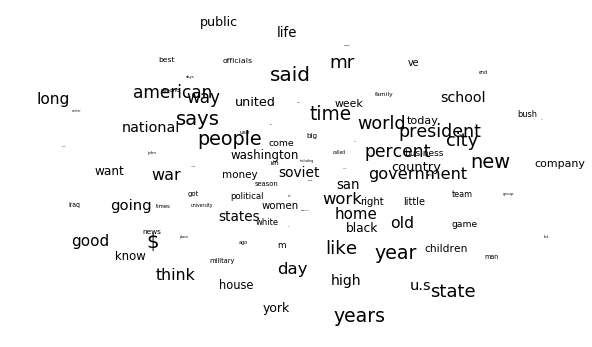

In [204]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords2[:, 0], tsneWords2[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords2[:, 0][i],tsneWords2[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

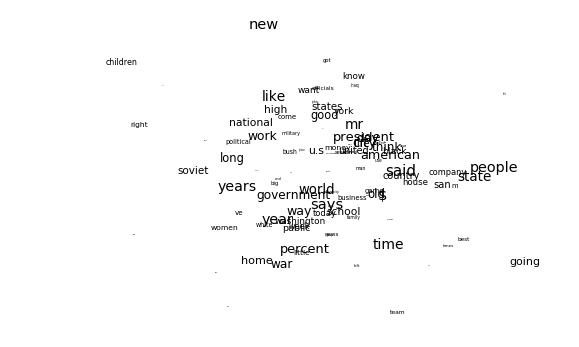

In [209]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data2[:, 0], reducedPCA_data2[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data2[:, 0][i],reducedPCA_data2[:, 1][i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Once again, PCA has more variability in Visualiation and seems to capture global patterns well (all political terms seem to be grouped together in the upper right quadrant). 

Below, I perform some word simliarties to begin to understand the vector embedding space.

In [213]:
m2.most_similar("news")

[('Latest_Tanker_Operator', 0.5560430288314819),
 ('MCOT_online', 0.5420750379562378),
 ('Pete_Tenney_KTEN', 0.5341694355010986),
 ('valfen@di-ve.com', 0.520783543586731),
 ('press', 0.5195180177688599),
 ('Charmaine_Chetcuti_di_ve', 0.5058273077011108),
 ('News', 0.5022889971733093),
 ('Ruben_Cassar_di_ve', 0.5015273094177246),
 ('media', 0.497778058052063),
 ('Visit_FinanceVisor', 0.4966496527194977)]

This is not giving any insight into the space at all.

In [212]:
m2.most_similar("war")

[('wars', 0.748465895652771),
 ('War', 0.6410670280456543),
 ('invasion', 0.5892109870910645),
 ('Persian_Gulf_War', 0.5890660285949707),
 ('Vietnam_War', 0.5886474847793579),
 ('Iraq', 0.588599443435669),
 ('unwinnable_quagmire', 0.5681803226470947),
 ('un_winnable', 0.5606350898742676),
 ('occupation', 0.5506216287612915),
 ('conflict', 0.5506187677383423)]

This corpus has more skepticism towards war('unwinnable_quagmire', 'un_winnable'). This suggests the conversation is pre-dominantly about the Second Gulf War and not the first.

In [215]:
m2.most_similar("journalist")

[('reporter', 0.7536268830299377),
 ('Journalist', 0.7519729733467102),
 ('freelance_journalist', 0.7406283020973206),
 ('investigative_journalist', 0.7187291383743286),
 ('photojournalist', 0.710208535194397),
 ('correspondent', 0.6768438816070557),
 ('investigative_reporter', 0.6683288812637329),
 ('journalists', 0.666439950466156),
 ('journo', 0.658358097076416),
 ('writer', 0.6535510420799255)]

Here we see alternative names as well as specific types of journalist and not qualities of journalists as we saw in the last model.

In [6]:
m2.most_similar("men")

[('women', 0.767493724822998),
 ('Men', 0.6301246881484985),
 ('males', 0.6242231130599976),
 ('mens', 0.5807526707649231),
 ('boys', 0.5781347751617432),
 ('man', 0.5489763021469116),
 ('females', 0.5481874942779541),
 ('teenagers', 0.5462744235992432),
 ('girls', 0.540932834148407),
 ('ladies', 0.5234236717224121)]

In [218]:
m2.most_similar("women")

[('men', 0.767493724822998),
 ('Women', 0.7283449769020081),
 ('womens', 0.6786179542541504),
 ('girls', 0.6339040398597717),
 ('females', 0.6240420937538147),
 ('mothers', 0.6050933599472046),
 ('ladies', 0.5865179300308228),
 ('husbands', 0.5705342292785645),
 ('transwomen', 0.5697939991950989),
 ('Men', 0.5693342089653015)]

In both cases, just as in the previous model, the associations are with gendered terms. However we do see the inclusion of "transwomen" in this corpus, which is a sign of changing times(and a indication that the google news corpus has articles later than from 1990/91). 

In [219]:
mm = m2.most_similar(positive=['journalist','woman'], negative=['man'])
for m in mm:
    print (m)

('freelance_journalist', 0.6719341278076172)
('reporter', 0.6439321041107178)
('Journalist', 0.6296682953834534)
('freelance_reporter', 0.5879244804382324)
('photojournalist', 0.5838879942893982)
('investigative_journalist', 0.5802053809165955)
('corespondent', 0.5753150582313538)
('investigative_reporter', 0.57012939453125)
('correspondent', 0.5599650144577026)
('journalists', 0.5541554093360901)


In this model, we see the various ways of addressing a journalist, but also different types of journalists. This could mean that this model is more comprehensive than the previous model.

In [220]:
mm = m2.most_similar(positive=['president','woman'], negative=['man'])
for m in mm:
    print (m)

('President', 0.6533178687095642)
('chairwoman', 0.5765142440795898)
('vice_president', 0.5682439804077148)
('chairperson', 0.5558825135231018)
('Vice_President', 0.5502278804779053)
('executive', 0.5394408702850342)
('Executive_Director', 0.5326347351074219)
('CEO', 0.5286189913749695)
('chief_executive', 0.5264196991920471)
('Chairperson', 0.4910368025302887)


Unlike the previous model, this analogy test, does atleast return "chairwoman". This suggests this model is better at capturing mordern gender relations better than the previous one.

In [5]:
mm = m2.most_similar(positive=['nurse','man'], negative=['woman'])
for m in mm:
    print (m)

('nurses', 0.5750778317451477)
('medic', 0.5732707977294922)
('registered_nurse', 0.5555101633071899)
('x_ray_technician', 0.5553552508354187)
('Nurse', 0.5527041554450989)
('doctor', 0.5420948266983032)
('respiratory_therapist', 0.5328323841094971)
('nursing', 0.5252007246017456)
('paramedic', 0.5221818089485168)
('physician', 0.500717043876648)


Once again, nurse on the gender dimension f

In [225]:
mm = m2.most_similar(positive=['wars','president'], negative=['war'])
for m in mm:
    print (m)

('President', 0.6419357061386108)
('CEO', 0.5829986333847046)
('presidents', 0.5740888118743896)
('vice_president', 0.5666695833206177)
('chief_executive', 0.5665820837020874)
('chairman', 0.5510209798812866)
('pesident', 0.5260305404663086)
('vice_presidents', 0.5160281658172607)
('COO', 0.5151299834251404)
('Vice_President', 0.509572446346283)


This model does capture some plularity, but the lack of token normalization seems to be an issue and ultimately "presidents" is not top choice in cosine similiarity.

In [6]:
mm = m2.most_similar(positive=['george_bush','vietnam'], negative=['iraq'])
for m in mm:
    print (m)

('reagan', 0.6072975993156433)
('jimmy_carter', 0.5461568236351013)
('chavez', 0.5361428260803223)
('singaporean', 0.531941831111908)
('rudy', 0.5318852663040161)
('rubio', 0.5290517210960388)
('bryan', 0.5289558172225952)
('johnny_depp', 0.5284807682037354)
('samuel', 0.5244619250297546)
('ronnie', 0.5239843726158142)


Interestingly, reagan and carter show up once more here, just like in the previous model, but no mention of any of the presidents during vietnam.

In [241]:
mm = m2.most_similar(positive=['washington','iraq'], negative=['states'])
for m in mm:
    print (m)

('iraqi', 0.623252809047699)
('afghanistan', 0.59364914894104)
('george_bush', 0.5930753946304321)
('washington_dc', 0.5795828104019165)
('obama', 0.5795443058013916)
('vietnam', 0.5717548131942749)
('reid', 0.567753791809082)
('bradley', 0.5657333135604858)
('cheney', 0.5563706755638123)
('iran', 0.5450378060340881)


Unlike the previous model, we don't get the capital of Iraq(Baghdad) but we do get Afghanistan(the other country US had a major war with during the second gulf war). The fact that Cheney appears as well as Bradley(cooper, presumably since he starred in a war movie) and Cheney suggests that the texts deal with Second Gulf war.  

In [13]:
mm = m2.most_similar(positive=['washington_dc','Iraq'], negative=['United_States'])
for m in mm:
    print (m)

('iraq', 0.6401218771934509)
('iraqi', 0.6029033660888672)
('george_bush', 0.5341247320175171)
('baghdad', 0.5228300094604492)
('afghanistan', 0.5086187720298767)
('pelosi', 0.5033352375030518)
('saddam', 0.49318623542785645)
('clintons', 0.4842187166213989)
('cheney', 0.48007500171661377)
('afganistan', 0.4788222312927246)


The capital Baghdad does show up, but not as high.

In [236]:
m2.most_similar('iraq')

[('afghanistan', 0.729322612285614),
 ('iraqi', 0.6724762916564941),
 ('Afganistan', 0.6447621583938599),
 ('afganistan', 0.6384879350662231),
 ('Iraq', 0.6277869343757629),
 ('iran', 0.608288049697876),
 ('libya', 0.6052850484848022),
 ('vietnam', 0.6033740639686584),
 ('cheney', 0.6009483337402344),
 ('iraqis', 0.5914427042007446)]

In [ ]:
In contrast to the previous model, we get more countries that the United States invaded (including Libya) which means the news corpus have recent documents.

Overall, we see that the google news corpus encapsulates a more comprehensive model of American imperialism beyond just the Iraq focus in the news articles from 90/91.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

In [ ]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

I am going to do a further exploration of Iraq war and related concepts of US militarism. My keywords reflect that choice.

In [7]:
keywords=['war','wars','gulf','vietnam','iraq','bush','presidents','reagan','carter','nixon','president']

In [8]:
new=[]
for l in newsDF['normalized_sents']:
    new.append([item for sublist in l for item in sublist])
newsDF['normalized_words']=new
ids=range(newsDF.shape[0])
newsDF['doi']=ids

In [9]:
dm=gensim.models.doc2vec.Doc2Vec()

In [10]:
taggedDocs = []
for index, row in newsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
newsDF['TaggedText'] = taggedDocs

In [11]:
newsD2V = gensim.models.doc2vec.Doc2Vec(newsDF['TaggedText'], size = 100) #Limiting to 100 dimensions

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [94]:
newsD2V['war'][:10]

array([-0.32281876, -0.7020581 , -0.08393887, -0.3505647 , -0.3049981 ,
       -1.5692484 ,  3.1322184 ,  0.23978809, -2.6941967 , -1.1692979 ],
      dtype=float32)

In [12]:
newsD2V.most_similar(positive = ['iraq','nixon'], negative = ['vietnam'], topn = 10)

[('fitzwater', 0.7760022878646851),
 ('mubarak', 0.7573145031929016),
 ('picco', 0.7326598763465881),
 ('marlin', 0.7283878326416016),
 ('hussein', 0.7209010720252991),
 ('hashemi', 0.7187118530273438),
 ('gates', 0.7077697515487671),
 ('aides', 0.7048813700675964),
 ('hosni', 0.7002269625663757),
 ('resignation', 0.698199987411499)]

I wanted to check if the nixon:vietnam relationship that is not captured by the Word2Vec model is captured by the Doc2Vec model and it seems like it is not as we don't get 'bush' in the top results.

In [101]:
newsD2V.most_similar(positive = ['wars','president'], negative = ['war'], topn = 5)

[('presidents', 0.6111900806427002),
 ('versa', 0.5592323541641235),
 ('cyanamid', 0.5432870388031006),
 ('shimbun', 0.5018364787101746),
 ('shatalin', 0.501613974571228)]

In [ ]:
Our Doc2Vec model, just like our Word2Vec model seems to capture plurality however.

In [104]:
newsD2V.docvecs.most_similar([ newsD2V['wars'] ], topn=5 )

[(2030, 0.6338689923286438),
 (4887, 0.5888708829879761),
 (2735, 0.5579837560653687),
 (3407, 0.5422875881195068),
 (2932, 0.5372608304023743)]

Let's examine the contents of the most similiar document '2030' to 'wars'

In [26]:
list(newsDF.loc[newsDF['doi'] == 2030]['text'])[0][:500]

"One February night in 1970 Phill Coleman 's outpost at Bien Hoa was rocketed twice he says by his own army Six American soldiers were slaughtered I and some of the guys got together right there and said if we survived the war we would do everything we could to educate the American public about what was happening in Vietnam Coleman who has written a book Cannon Fodder about the attack started the country 's first Vietnam computer library in Redondo Beach in 1988 The quest for knowledge from acros"

So we get a text about the Vietnam war. Let's find documents similiar to that.

In [105]:
newsD2V.most_similar( [ newsD2V.docvecs[2030] ], topn=5)

[('grateful', 0.7344169020652771),
 ('harbinger', 0.7344008684158325),
 ('fuss', 0.7290758490562439),
 ('brainy', 0.7256369590759277),
 ('unnoticed', 0.7247389554977417)]

We get words that are not about the war. This means there are other salient dimensions to the same text, and the text's association with war is a funciton of our keyword tagging. However we do see some words that indicate doom ('harbinger, unnoticed').

In [106]:
newsD2V.most_similar( [ newsD2V.docvecs[4887] ], topn=5)

[('untold', 0.9092534184455872),
 ('doom', 0.8971071839332581),
 ('deserved', 0.8899451494216919),
 ('accustomed', 0.8836345672607422),
 ('unpunished', 0.8775908946990967)]

Another document second most similiar to war has similiar charecteristics as the first. This suggests that W2V models will be great at topic modelling.

In [30]:
newsD2V.most_similar(positive = ['bush','vietnam'], negative = ['iraq'], topn = 5)

[('truman', 0.6820322275161743),
 ('carter', 0.6089875102043152),
 ('kennedy', 0.5881960391998291),
 ('havel', 0.5797588229179382),
 ('pope', 0.5781103372573853)]

Our Doc2Vec model still can finally figure out presidents during vietnam(Kennedy is one). 

In [109]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = newsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, newsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

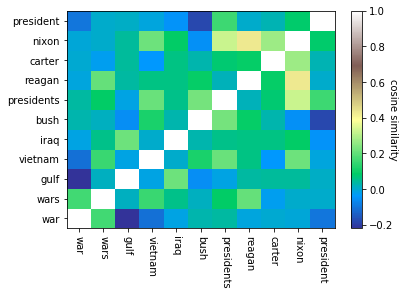

In [110]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

This heat map isn't very informative overall due to the high number of low sin similarity scores. It does show however Nixon is simniliar in this space to Reagan which does make sense, given the war related scandals both were involved in. However there might other similiarries the model is picking up. Vietnam also have high similiarity with Nixon while Iraq with Bush. This suggests Doc2Vec models can be used to query relationships between presidents and the countries they lead a war against.

In [119]:
newsD2V.save('newsW2V')

In [120]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [66]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [67]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [68]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

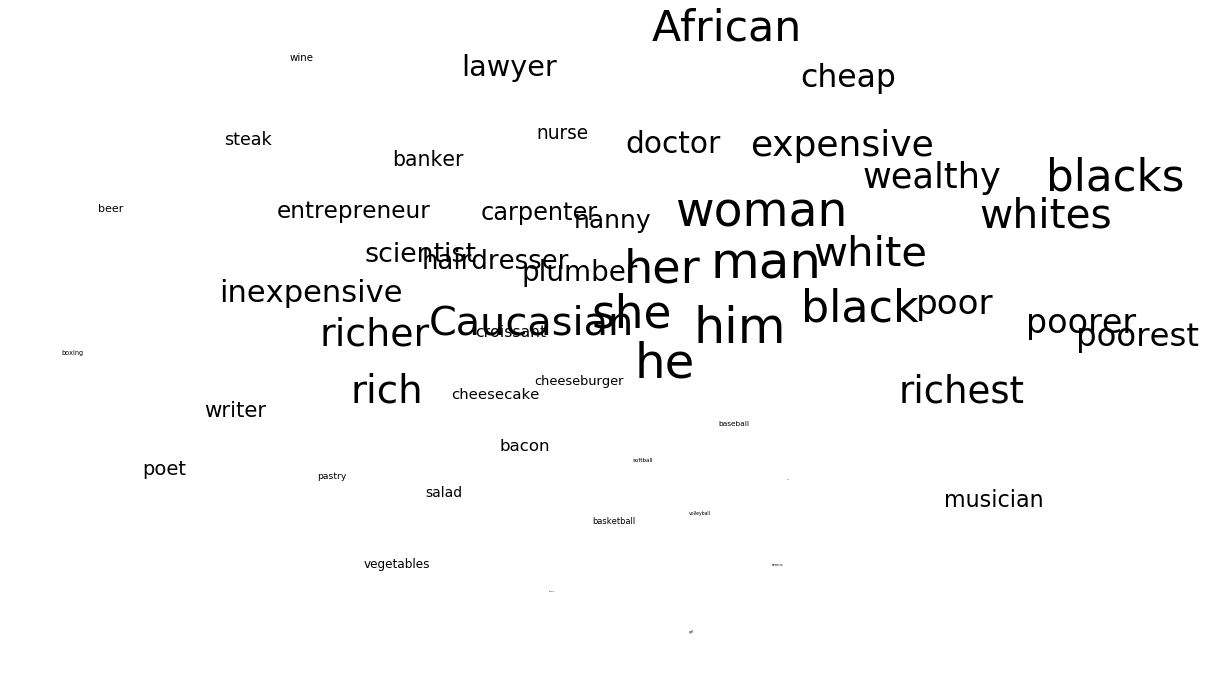

In [69]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

For this exercise, I created two dimensions, Political Orientation and Press Freedom. I wanted to specifically map Race onto press these categories to figure out if there is a racial difference in political orientation and (opinions on) press freedom. I also map Occupations, Music genres and Institutions.

In [3]:
m2=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model=m2
#words to create dimensions
tnytTargetWords = ['liberal','socialist','communist','libertarian','trusted','fake','free','censored','freedom','jail','democrat','republican','rich','working','russia','states']
#words we will be mapping
tnytTargetWords += ["journalist","president","rabbi","politician","senator","businessman","entrepreneur", "banker", "punk", "rap", "jazz", "opera", "rock","blues", "funk", "folk", "black","hispanic","indian","asian","arab","white"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [4]:
#Use TSNE visualiation as it's better at caputuring local patterns which maybe useful if the categories cluster together
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(wordsSubMatrix)

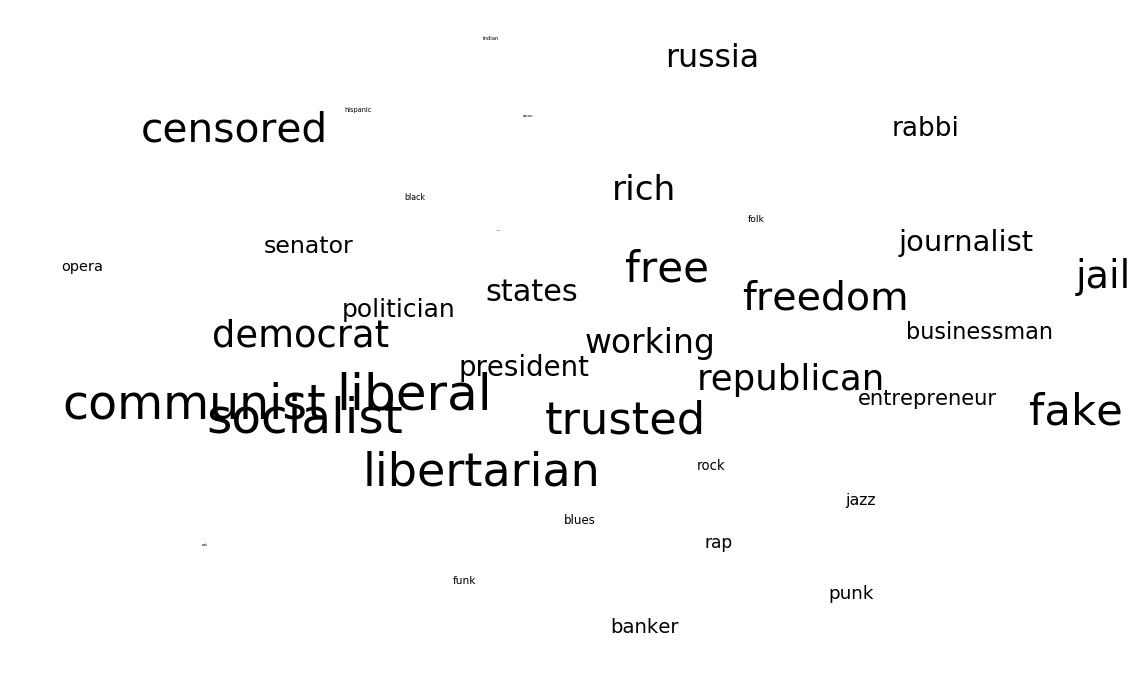

In [5]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Seems like the political orientations cluster on the left bottom('socialist','libertarian', etc.) the occuptions on the right side('rabbi','journalist','entreprenuer'), musical categories on the bottom right('funk','rap','punk','jazz'). This suggests that the vector semantic space is reasonable.

In [25]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [44]:
Orientation = dimension(model, ['liberal','socialist','anarchist','democrat', 'left'], ['conservative','libertarian','fascist','republican','right'])
Press = dimension(model, ['trusted','free','freedom'], ['fake', 'jail', 'censored'])

In [51]:
Occupations = ["journalist","president","rabbi","politician","senator","businessman","entrepreneur", "banker"]

Music = ["punk", "rap", "jazz", "opera", "rock","blues", "funk", "folk"]

Race= ["black","hispanic","indian","asian","arab","white"]

Institutions =['media','hospitals','school','congress','college']



In [52]:
def makeDF(model, word_list):
    o = []
    p = []
   
    for word in word_list:
        o.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Orientation.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Press.reshape(1,-1))[0][0])

    df = pandas.DataFrame({'political orientation': o, 'press freedom': p}, index = word_list)
    return df

In [53]:
OCCdf = makeDF(model, Occupations) 
Musicdf = makeDF(model, Music)
Racedf = makeDF(model, Race)
Idf = makeDF(model, Institutions)

In [54]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

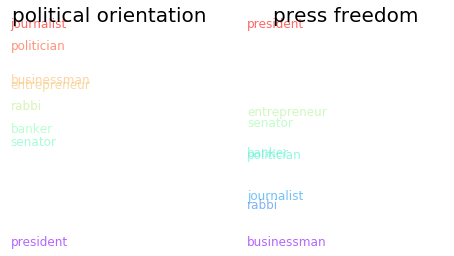

In [55]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'political orientation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'press freedom')
plt.show()

I project occupations above and it seems clear that, in political orientation Journalist is on the liberal/socialist end of the spectrum while president is on the right end of the spectrum. This confers with the perception of public that the media in the united states is liberal, while the political policy(both "senator", "president") and "banker(s)" that fund them are on the right of the population. The rabbi seems to be apolitical/centrist in the middle. When occupation is projected onto press freedom, the president who has the most power to endanger press freedom in the United States ends up on the opposite side of journalist. Interestingly, 'rabbi' and 'businessman' are even further away from president, which is interesting but hard to interpret.

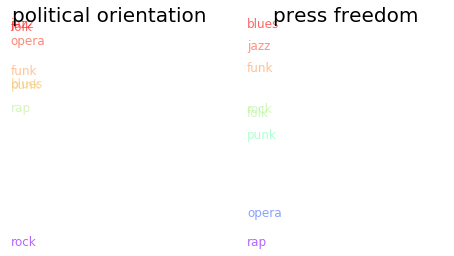

In [56]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Musicdf, 'political orientation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Musicdf, 'press freedom')
plt.show()

In Musical orientation, 'folk' and 'opera' are on the opposite side of 'punk', which also makes sense and confirms with popular perceptions. It's hard to interpret music genres projected on press freedom, I just present it here for illustrative purposes.

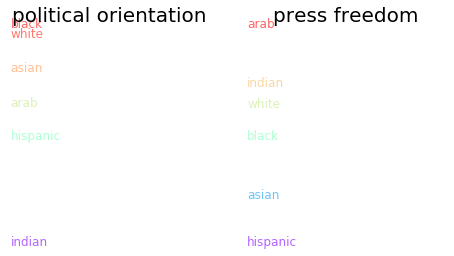

In [57]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Racedf, 'political orientation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Racedf, 'press freedom')
plt.show()

The interpretation of projection of race on political orientation is hindered by the fact that "African_american", "Caucasian" is not part of the word2vec model and using words with polysemy like "black", "white", 'arab' does not lead to reasonable results as we aren't sure if these words refer to racial categories as they pertain to the united states or otherwise. This is a limitation of the word2vec which is overcome by BERT/ELMO models with contextual embeddings

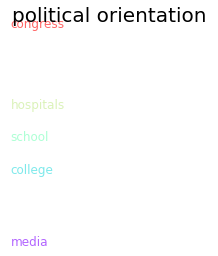

In [59]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Idf, 'political orientation')
plt.show()

I projected public institutions on political orientation and it made sense to me. Institutions like congress are seen more conservative than the media and colleges in the country. 'Hospital(s)' and 'school(s)' seem apolitical/centrist.

Overall projections on interesting dimensions do lead to insights, but the anthropologist needs to come in with enough understanding of the problem at hand to intrepret the results, it seems.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [ ]:
import copy

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [ ]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
ascoDF

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [20]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    print("In rawModels")
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        print (cat)
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

The most divergent words are:

In [ ]:
wordDivergences[:20]

And the least:

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

I used the COHA corpus, because I was interested in the trajectory of words during three periods (the period from 1870 to 1945), (1945 to 74) and beyond. The reason for this split is, as Robert J. Gordon outlines in his book, "The rise and fall of American growth", 1870 was the beginning of a century that transformed American economy. I split this into two parts, the pre WW2 and the post WW2 time. I then make a split at 1974 when the american economy stopped growing for the working class. I thought this time split this way will lend itself to a reasonable introspection of political terms. 

In [22]:
corpora_address = "./COHA"

In [23]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1830s_bsu.zip
text_1810s_kso.zip
text_1930s_bie.zip
text_1990s_bsj.zip
text_1890s_jsq.zip
text_1850s_jpr.zip
text_1870s_vuy.zip
text_1980s_bkk.zip
text_1840s_nsq.zip
text_1900s_mse.zip
text_1970s_jfy.zip
text_1820s_jsi.zip
text_1960s_xus.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1880s_azz.zip
text_1950s_ndz.zip
text_1940s_bsw.zip
text_2000s_scc.zip
text_1860s_psi.zip


I include the codeblock below to show the loading of the embeddings given in the HW don't work since the pickle version used to save the embeddings are different from the pickle version on RCC, so I had to create my own Embeddings.

In [116]:
original_rawEmbeddings_epoch_load = file_to_original_embeddings(".", "epoch")

ModuleNotFoundError: No module named 'numpy.random._pickle'

I decided to sample documents at random since the number of documents was too high to process in whole.

In [25]:
import random
random.seed(13)
n_articles=5000
subset_keys = random.sample(list(coha_texts.keys()), n_articles)


I corrected the errors in the original code to tokenize/normalize sentences which is what the w2v model takes in.

In [ ]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])
i=0
#print ("Processing epoch", 1)
for article in subset_keys:
    genre, year, id_ = article.split("_")
    
    i+=1
    year = int(year)
    
    if (year<1870):
        continue
    
    if year >= 1870 and year < 1945:
        epoch = 1
    elif year >= 1945 and year < 1974:
        epoch = 2
    elif year >= 1974:
        epoch = 3
    #if (prev_epoch!=epoch):
        #print("Processing epoch", epoch)
    #if (prev_year!=year):
        #print("Year", year)   
    if ((i%50)==0):   
        print("Article: ", i, "of ", n_articles)
    try:
        if len(coha_texts[article][2]) < 1500000 and (year>=1870):
            #Apply our functions, notice each row is a list of lists now
            token_sents = [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(coha_texts[article][2].decode("utf-8"))]
            normalized_sents = [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in token_sents]
            coha_df.loc[id_] = [year, genre, epoch, normalized_sents]
    except TypeError:
        print("TypeError")
        continue
    except IndexError:
        print("IndexError")
        continue
    

In [ ]:
#Saving the corpus so that it's easier to load later
newsDF.to_pickle("./cohaDF.pkl")

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch+1)
    model.save(name)

In [ ]:
rawEmbeddings_epoch.keys()

In [117]:
with open('RawEmbeddings.pickle', 'wb') as handle:
    pickle.dump(rawEmbeddings_epoch, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('RawEmbeddings.pickle', 'rb') as handle:
     rawEmbeddings_epoch= pickle.load(handle)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [14]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = gensim.models.word2vec.Word2Vec.load(file)
    return rawEmbeddings

In [112]:
def file_to_original_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embeddingo_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [16]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

In [ ]:
#Find the most divergent words
wordDivergences = findMostDivergent(compared_epoch)

In [92]:
wordDivergences[:40]

[('israel', 2.233654223382473),
 ('s', 1.7662663757801056),
 ('lovell', 1.6561808735132217),
 ('t', 1.5552900731563568),
 ('wharton', 1.5071788132190704),
 ('williamson', 1.436507523059845),
 ('bert', 1.4121887385845184),
 ('ruth', 1.3612160682678223),
 ('book', 1.360591098666191),
 ('haven', 1.358679622411728),
 ('d', 1.3573620319366455),
 ('figure', 1.352883979678154),
 ('takes', 1.349026471376419),
 ('o', 1.3443649113178253),
 ('mrs', 1.342719942331314),
 ('great', 1.326803833246231),
 ('suit', 1.3110176622867584),
 ('duke', 1.309838205575943),
 ('david', 1.3063606321811676),
 ('new', 1.2959939539432526),
 ('prince', 1.2954888939857483),
 ('ito', 1.290746659040451),
 ('title', 1.289797306060791),
 ('keller', 1.2823844850063324),
 ('gave', 1.2789965569972992),
 ('shall', 1.2713885754346848),
 ('mr', 1.2710423097014427),
 ('brand', 1.2613412141799927),
 ('gentleman', 1.2571472823619843),
 ('took', 1.2455247640609741),
 ('de', 1.2428947985172272),
 ('reading', 1.2403151392936707),
 ('b

As stated above, I am interested in the words that are related to American economic life and their trajectory but I will also explore Israel whose changing trajectory is perhaps reflective of its relatively recent creation as a state.

israel


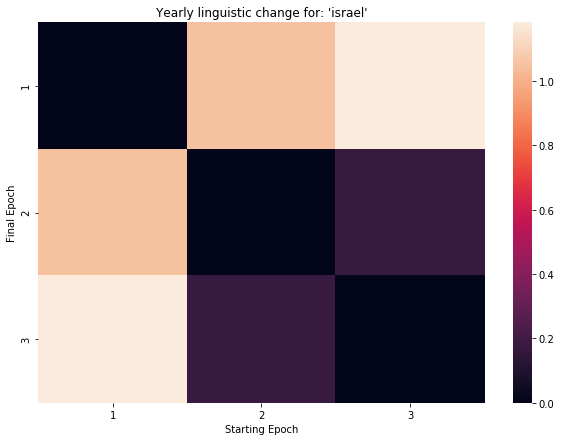

In [93]:
targetWord = 'israel'

pltDF = getDivergenceDF(targetWord, compared_epoch)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting Epoch")
ax.set_ylabel("Final Epoch")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [32]:
d1=rawEmbeddings_epoch_load[1]
d1.most_similar(['israel'])[:5]

[('host', 0.8635767698287964),
 ('sam', 0.8633328676223755),
 ('anxiously', 0.8629122972488403),
 ('quietly', 0.858458936214447),
 ('impatiently', 0.8548005819320679)]

In [40]:
d2=rawEmbeddings_epoch_load[2]
d2.most_similar(['israel'])[:5]

[('ratify', 0.9869929552078247),
 ('treaty', 0.9858265519142151),
 ('italy', 0.9853824377059937),
 ('negotiations', 0.9832497239112854),
 ('nato', 0.9825923442840576)]

In [41]:
d3=rawEmbeddings_epoch_load[3]
d3.most_similar(['israel'])[:5]

[('communist', 0.9745593070983887),
 ('nation', 0.9656575918197632),
 ('iran', 0.9646111726760864),
 ('independent', 0.9627575874328613),
 ('union', 0.9594548940658569)]

We see from the graph that the most change is from epoch 1 to epoch 2(before and during creation of the state). Looking at how the word associations change, we get that 'israel' took on its political use in this corpus from the second epoch onwards. This might indicate that the politicalization of a state's name increases as it comes closer to attaining statehood but doesn't change much after the fact.

liberalism


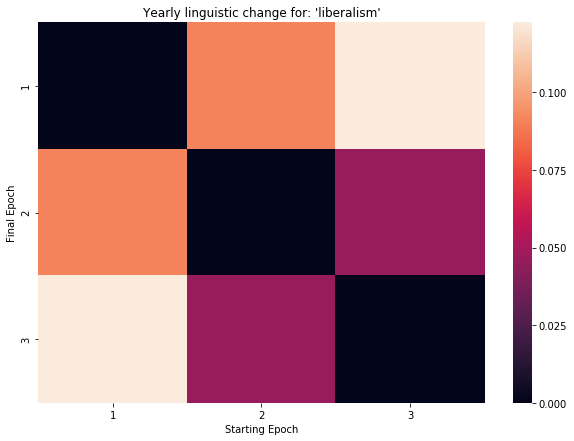

In [98]:
targetWord = 'liberalism'

pltDF = getDivergenceDF(targetWord, compared_epoch)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting Epoch")
ax.set_ylabel("Final Epoch")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [49]:
d1.most_similar(['liberalism'])[:10]

[('antagonism', 0.9764421582221985),
 ('endeavors', 0.9722557663917542),
 ('outweigh', 0.9708786010742188),
 ('radicalism', 0.969334602355957),
 ('remoteness', 0.9685097932815552),
 ('contradiction', 0.9676932692527771),
 ('repetition', 0.9674183130264282),
 ('confusing', 0.9670988321304321),
 ('idealistic', 0.9661967158317566),
 ('baffling', 0.9655587673187256)]

In [50]:
d2.most_similar(['liberalism'])[:10]

[('rebel', 0.9954395294189453),
 ('continuity', 0.9946475028991699),
 ('theology', 0.9945688247680664),
 ('adherent', 0.9944310188293457),
 ('crusader', 0.9943629503250122),
 ('merlin', 0.9938899874687195),
 ('histories', 0.9937558174133301),
 ('robinson', 0.9934170842170715),
 ('predecessor', 0.9933492541313171),
 ('unsatisfactory', 0.9931560754776001)]

In [51]:
d3.most_similar(['liberalism'])[:10]

[('systematic', 0.9943816661834717),
 ('focuses', 0.9940147399902344),
 ('vital', 0.9939244389533997),
 ('autonomy', 0.9936704039573669),
 ('mechanism', 0.9930646419525146),
 ('sufficiently', 0.9929953813552856),
 ('influences', 0.9929242730140686),
 ('ensuring', 0.9926134347915649),
 ('learners', 0.992457926273346),
 ('consistent', 0.9924157857894897)]

From the graph, the most change occurs from the first to the second epoch. This makes sense too as, liberalism actualized in the early part of the 20th century in the United States and across the world as a coherent political ideology that can underpin nation states. Perhaps once an ideology actualizes, it's characteristics in text remains constant.

socialism


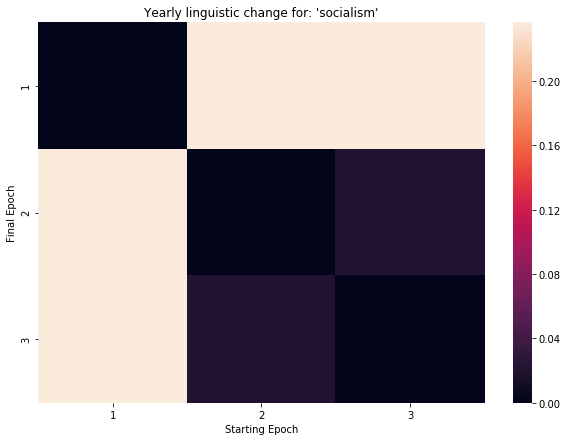

In [96]:
targetWord = 'socialism'

pltDF = getDivergenceDF(targetWord, compared_epoch)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting Epoch")
ax.set_ylabel("Final Epoch")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [52]:
d1.most_similar(['socialism'])[:10]

[('practices', 0.9664442539215088),
 ('advocates', 0.9660531282424927),
 ('outset', 0.9653066992759705),
 ('cooperation', 0.9622966647148132),
 ('liberties', 0.9610468149185181),
 ('nationalism', 0.9590631723403931),
 ('governed', 0.9564797282218933),
 ('involves', 0.953182578086853),
 ('vitally', 0.9529298543930054),
 ('discrimination', 0.9513082504272461)]

In [53]:
d2.most_similar(['socialism'])[:10]

[('z', 0.9975436329841614),
 ('disturbances', 0.9974865913391113),
 ('bourgeoisie', 0.9972890615463257),
 ('poets', 0.997165858745575),
 ('agitation', 0.9970198273658752),
 ('abandon', 0.9969402551651001),
 ('exploited', 0.9968626499176025),
 ('tendencies', 0.9968617558479309),
 ('akin', 0.9968568682670593),
 ('influences', 0.9967920184135437)]

In [54]:
d3.most_similar(['socialism'])[:10]

[('challenging', 0.995447039604187),
 ('biblical', 0.9954203367233276),
 ('imperative', 0.9942939281463623),
 ('desired', 0.9938770532608032),
 ('monographs', 0.9938390254974365),
 ('unclear', 0.9935222864151001),
 ('explicit', 0.9935112595558167),
 ('amelioration', 0.993480920791626),
 ('marxists', 0.9933738708496094),
 ('fulfilling', 0.9933003187179565)]

Once again, from the graph, the most change occurs from the first to the second epoch. This makes sense too as, socialism turned in the early part of the 20th century as a viable political philosophy to being demonized after WW2 as a coherent political ideology that can underpin nation states. This is reflected in these word similarity tests too where the words go from positive in the first epoch to negative/mixed in the second and third. I will now look at words that do not diverrge much over the epochs below.

In [103]:
#Looking at the lowest divergences
wordDivergences[-40:]

[('virtual', 0.060771286487579346),
 ('gaped', 0.06072777509689331),
 ('glamour', 0.060348451137542725),
 ('hazards', 0.06015658378601074),
 ('tremendously', 0.05995607376098633),
 ('mumble', 0.05934947729110718),
 ('deposition', 0.05929899215698242),
 ('wallowing', 0.05926769971847534),
 ('compounds', 0.05797278881072998),
 ('employs', 0.057855069637298584),
 ('jubilant', 0.057450175285339355),
 ('mediocre', 0.05743628740310669),
 ('testifies', 0.057353973388671875),
 ('derives', 0.05699378252029419),
 ('repression', 0.05673593282699585),
 ('squeaked', 0.05616098642349243),
 ('sanctuary', 0.05518901348114014),
 ('trailed', 0.05511373281478882),
 ('distinguishing', 0.05481797456741333),
 ('recoiled', 0.05429220199584961),
 ('jostling', 0.054232776165008545),
 ('operates', 0.05402815341949463),
 ('unused', 0.05377715826034546),
 ('triumphantly', 0.05370748043060303),
 ('giggled', 0.053681373596191406),
 ('entrenched', 0.05355119705200195),
 ('oils', 0.0530010461807251),
 ('sonic', 0.052

It's interesting that a good part of these least divergent words are related to human actions('jostling', 'bristled', 'mumble', etc.). This suggests that there is a stability to human gestures and words which makes total sense. I do a word similarity test in each epoch to better understand the vector space.

In [64]:
d1.most_similar(['bristled'])[:10]

[('entangled', 0.9779433012008667),
 ('spasmodically', 0.9761455655097961),
 ('powders', 0.9749782085418701),
 ('punctured', 0.9748271703720093),
 ('dwindling', 0.9743689298629761),
 ('originates', 0.973301887512207),
 ('fibrin', 0.972484827041626),
 ('taunt', 0.9724241495132446),
 ('inextricably', 0.9712799787521362),
 ('releases', 0.9706199169158936)]

In [65]:
d2.most_similar(['bristled'])[:10]

[('tangled', 0.996044397354126),
 ('scrolls', 0.9960352778434753),
 ('flanks', 0.9959973692893982),
 ('lurid', 0.995853066444397),
 ('belts', 0.9956988096237183),
 ('kit', 0.9956041574478149),
 ('cuff', 0.9955862760543823),
 ('tomato', 0.9955333471298218),
 ('braced', 0.9954825639724731),
 ('tensely', 0.9953988194465637)]

In [66]:
d3.most_similar(['bristled'])[:10]

[('nicely', 0.9963277578353882),
 ('gunman', 0.9960675835609436),
 ('irrepressible', 0.9951126575469971),
 ('clippings', 0.9951070547103882),
 ('stomps', 0.994377076625824),
 ('yea', 0.9943550825119019),
 ('desperation', 0.9943538904190063),
 ('steamy', 0.9943025708198547),
 ('harden', 0.9941403865814209),
 ('feigned', 0.9941352009773254)]

Looking at the word similarity scores from each epoch for 'bristled' we do get different words, but the semantic content of those words remain stable('spasmodically' in epoch 1, 'tensely' in epoch 2, 'harden' in epoch 3). This suggests that this vector space model is capturing some deep semantics and not just pure word associations.

In [68]:
d1.most_similar(['mumble'])[:10]

[('propagandist', 0.980863094329834),
 ('rousing', 0.9793975353240967),
 ('diem', 0.9787631034851074),
 ('riotous', 0.9780648946762085),
 ('fragment', 0.9778451919555664),
 ('rasping', 0.9776821136474609),
 ('lotions', 0.9774767160415649),
 ('fatality', 0.9771629571914673),
 ('devour', 0.9769116640090942),
 ('scaffold', 0.976620078086853)]

In [67]:
d2.most_similar(['mumble'])[:10]

[('pilgrims', 0.9958810806274414),
 ('swift', 0.9953616857528687),
 ('breaking', 0.9953151941299438),
 ('wound', 0.9952400922775269),
 ('crashed', 0.9951286315917969),
 ('melting', 0.9950600266456604),
 ('avoiding', 0.9949589967727661),
 ('perch', 0.9948956966400146),
 ('images', 0.994857907295227),
 ('aft', 0.994661808013916)]

In [69]:
d3.most_similar(['mumble'])[:10]

[('throng', 0.9892956018447876),
 ('conceal', 0.9878409504890442),
 ('whores', 0.9877729415893555),
 ('kin', 0.9871506094932556),
 ('slaughtered', 0.9870074987411499),
 ('powerless', 0.9867876768112183),
 ('monster', 0.9867838621139526),
 ('freaks', 0.9867438077926636),
 ('weary', 0.9865779280662537),
 ('utter', 0.9862973093986511)]

Once again, looking at the word similarity scores from each epoch for 'mumble' we do get different words, but the semantic content of those words remain stable('riotous' in epoch 1, 'breaking' in epoch 2, 'throng' in epoch 3). This once again suggests that this vector space model is capturing some deep semantics and not just pure word associations.